In [1]:
import numpy as np
from scipy import sparse
from math import sqrt
import matplotlib.pyplot as plt
import networkx as nx
import random

In [2]:
class geometric_network():
    def __init__(self, network_type, size, **kwargs):
        ####################################
        ##### Geometric Network Object #####
        ####################################
        
        ### input -- network_type:
        ##                      2D_lattice: creates 2d lattice of given tiling-can be triangular,square, hexagonal
        #                                   --Additional Arguments--
        #                                     tiling = 3,4,6
        #                                     periodic = bool (connects the edge of the grid to the opposite edge)
        ##                      ring_lattice: creates a ring graph with each node degree 2
        #                                    --Additional Arguments--
        #                                     banded=bool
        #
        ##                      chain_lattice:
        #                                     
        ### input -- size: network size, if 2D_lattice, then there will be size^2 many nodes.
        
        ### attribute -- geometric_network.size -- TODO(fix sizes, sizes are different for tiling 4 and 3,6)
        ### attribute -- geometric_network.graph
        ### attribute -- geometric_network.pos
        ### attribute -- geometric_network.A
        
        
        if network_type == '2D_lattice': 
            tiling = kwargs['tiling']
            per = kwargs['periodic']
            if tiling == 3: 
                self.graph = nx.triangular_lattice_graph(size, size, periodic = per, with_positions = True)
                self.pos = nx.get_node_attributes(self.graph,'pos')
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
                

            elif tiling == 4: 
                self.graph = nx.grid_2d_graph(size, size, periodic = per)
                self.pos = dict( (n, n) for n in self.graph.nodes() )
                self.labels = dict( ((i, j), i * size + j) for i, j in self.graph.nodes() )
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
                
            elif tiling == 6: 
                self.graph = nx.hexagonal_lattice_graph(size, size, periodic = per, with_positions = True)
                self.pos = nx.get_node_attributes(self.graph,'pos')
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
            
        elif network_type == 'ring_lattice':
            if kwargs['banded']: pass
            else:
                self.graph = nx.cycle_graph(size)
                theta = (2*np.pi)/size
                self.pos = dict((i,(np.sin(theta*i),np.cos(theta*i))) for i in range(size))
                self.M = len(self.graph.edges())
                self.N = len(self.graph.nodes())
            
            
        #elif network_type == 'chain_lattice':
            #if banded:
                
            #else:
            
        self.A = nx.adjacency_matrix(self.graph)## use .toarray() or .todense() attributes to call the sparse matrix
              
    def display(self, n_size = 15, labels = True):
        
        try: return(nx.draw(self.graph,pos=self.pos, node_size = n_size, with_labels = labels))
        
        except: return(nx.draw(self.graph))
        
    def add_noise_to_geometric(self, d2, noise_type):
        
        M = self.N * d2
        
        if noise_type == 'ER_like':   
            A = sparse.lil_matrix(self.A)
            edges_built = 0
            while edges_built < M/2:
                nodes_to_connect = [random.randint(0,self.N-1) for i in range(2)]
                if nodes_to_connect[0] == nodes_to_connect[1]: #no self-loops
                    edges_built = edges_built
                elif self.A[nodes_to_connect[0]][nodes_to_connect[1]] == 1: # no existing loops
                    A._set_intXint(nodes_to_connect[0],nodes_to_connect[1],1)
                    edges_built = edges_built
                else: 
                    A._set_intXint(nodes_to_connect[0],nodes_to_connect[1],1)
                    A._set_intXint(nodes_to_connect[1],nodes_to_connect[0],1)
                    edges_built = edges_built + 1
                    
        elif noise_type == 'k_regular':
            
            flag_2 = True
            
            while flag_2:
                flag_2 = False
                stubs = np.zeros((M,1))
                #for i in range(self.N):#???
                #build undirected link list
                link_list = np.zeros((M/2,2))
                for m in range(M/2):
                    flag_1 = True # turn on flag to enter while loop
                    count = 0
                    while flag_1:
                        flag_1 = False #turn off flag to exit while loop
                        rand = [random.randint(0,len(stubs)-1) for i in range(2)]
                        node_A = stubs[rand[0]]
                        node_B = stubs[rand[1]]
                        
                        if node_A == node_B: break # breaks the innermost loop if self-loops exist
                        
                        for n in range(m):pass
                        
        else: return('Noise type can only be ER_like or k_regular')
    
    def tweak_sparse_matrix(self, tweaked, rows, cols, vals): #tweaked is the sparse matrix, rows,cols,vals are lists
        #returns: tweaked sparse.csr_matrix
        data = np.array(vals, dtype = np.int32)
        rows = np.array(rows)
        cols = np.array(cols)
        sparsed = sparse.csr_matrix((data,(cols,rows)), shape = tweaked.shape)
        return(sparsed)
        
    def run_excitation(self, p, pstart, T, Trials, seed, threshold, spy = True):
        n = self.N
        first_activation_times = np.zeros((n,Trials), dtype = np.int32)
        if spy: fig,ax = plt.subplots(Trials,1, figsize = (3*Trials, 20))
        for i in range(Trials):
    
            x = sparse.csr_matrix((n, T+1), dtype = int)
            initial_cluster = np.nonzero(self.A[seed])[1].tolist()
            deg = len(initial_cluster)
            ps = np.array([random.uniform(0,1) for i in range(deg)])
            pstarts = np.array([1-pstart for i in range(deg)])
            vals = ps > pstarts
            rows = [0 for i in range(deg)]
            x_1 = self.tweak_sparse_matrix(x, rows, initial_cluster, vals.tolist())
    
            for t in range(T):
                x_old = x_1.toarray()[:,t]
                excited_nodes = np.nonzero(x_old)[0]
        
                if sum(a for a in first_activation_times[:,i] if a>0) < n:##when it's less than n, wave doesn't
                ##propagate for end nodes. maybe try n*t?
                    for j in excited_nodes:
                        if first_activation_times[j,i] == 0:
                            first_activation_times[j,i] = t
                    
                for j in list(set([k for k in range(n)])-set(excited_nodes)): 
                    ids = np.nonzero(self.A[j])[1]
                    rands = [random.uniform(0,1) for i in range(len(ids))]
                    val = int(sum(x_old[e]*rands[y] for y,e in enumerate(ids) if x_old[e]*rands[y]>1-p) >= threshold)
                    x_2 = x_1.tolil()
                    x_2._set_intXint(j,t+1,val)
                    x_1 = x_2.tocsr()
                    
            if spy: 
                ax[i].imshow(x_1.todense())
                ax[i].set_title('Trial %d'%(i+1))
                ax[i].set_xlabel('Time')
                ax[i].set_ylabel('Node ID')
                ax[i].set_xticks([5*t for t in range(int(T/5))])
                plt.tight_layout()

        return(x_1, first_activation_times)

    def spy_first_activation(self, first_activation_times):
        fig,ax = plt.subplots(1,1,figsize = (10,4))
        pos = ax.imshow(first_activation_times, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis')
        ax.set_title('First Activation Times')
        ax.set_xlabel('Trials')
        ax.set_ylabel('Node ID')
        fig.colorbar(pos, ax = ax)

In [3]:
t = 4 # tiling
n = 100 # network size
p = 0.7 # cascade spreading probablioty
pstart = 0.95 # first spread probability
T = 200 # number of iterations
Trials = 3 # number of trials
seed = int(n/2) # node that the spread starts
threshold = 0.1 # resistence of the node to it's neighbors' excitation level

In [4]:
#twoD_latt = geometric_network('2D_lattice', size = n, tiling = t, periodic = False)
ring_latt = geometric_network('ring_lattice', size = n, banded = False)

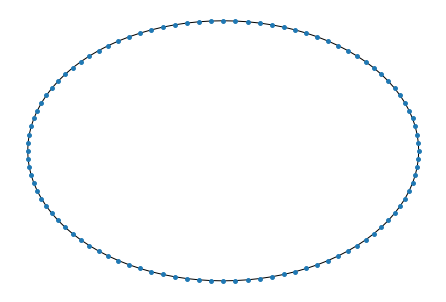

In [5]:
ring_latt.display(labels = False)

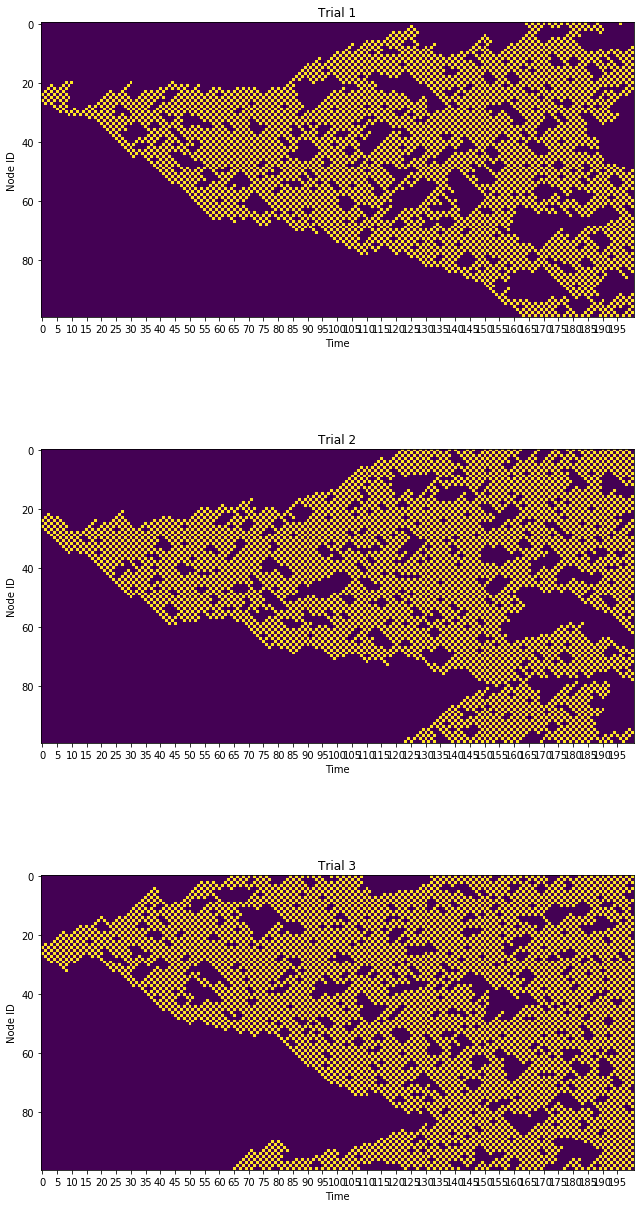

In [6]:
x_1, first_exct = ring_latt.run_excitation(p = p, pstart = pstart, T = T, Trials = Trials, seed = int(seed/2), threshold = threshold)

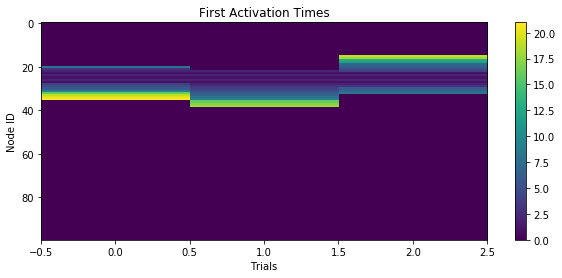

In [7]:
ring_latt.spy_first_activation(first_exct)